In [1]:
import torch
torch.cuda.is_available()

True

In [1]:
import os
import re
import scvi
import torch
import anndata
import pynndescent
import numba
import h5py
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.cm as cm
import scvelo as scv

[rank: 0] Global seed set to 0
/hpc/pmc_rios/2.personal/rariese/miniconda/envs/scanpy/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
plt.rcParams['figure.figsize']=(7,7)
torch.set_float32_matmul_precision('high')

In [3]:
h5_path='/hpc/pmc_rios/2.personal/rariese/scseq_analysis/BRO/time_course/data/Braun_dev_brain/HumanFetalBrainPool.h5'
ref_adata_path='/hpc/pmc_rios/2.personal/rariese/scseq_analysis/BRO/time_course/data/Braun_dev_brain/braun_2024_fetal_brain_filtered.h5ad'
hnoca_adata_path="/hpc/pmc_rios/2.personal/rariese/scseq_analysis/BRO/time_course/data/HNOCA/hnoca_pre-release_public_subset.h5ad"
adata_path="/hpc/pmc_rios/2.personal/rariese/scseq_analysis/BRO/time_course/data/BRO_timecourse/BRO_RA1_exp023_annotated.h5ad"
ref_adata_neuron_path = "/hpc/pmc_rios/2.personal/rariese/scseq_analysis/BRO/time_course/data/Braun_dev_brain/braun_2024_fetal_brain_filtered_neuron_subset.h5ad"

In [4]:
adata = sc.read_h5ad(adata_path)

# Subset for PSC & neuroepithelium

In [5]:
adata.obs['hnoca_leiden_level_3'].value_counts()

Neuroepithelium         24311
Medulla NPC              7250
MC                       7136
Ventral Midbrain NPC     3515
Medulla Neuron           3488
Pons NPC                 3463
PSC                      1346
Hypothalamic NPC         1207
Dorsal Midbrain NPC      1084
Glioblast                 998
OPC                       555
Cerebellar NPC            350
NC Derivatives            305
Astrocyte                 190
Hypothalamic Neuron       129
Name: hnoca_leiden_level_3, dtype: int64

In [6]:
prog = ["PSC","Neuroepithelium"]

query_adata = adata[adata.obs['hnoca_leiden_level_3'].isin(prog)].copy()
query_adata

AnnData object with n_obs × n_vars = 25657 × 23409
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mito', 'percent.ribo', 'nCount_SCT', 'nFeature_SCT', 'singlets', 'Day', 'n_counts', 'log_counts', 'n_genes', 'mt_fraction', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'leiden', 'leiden_res_1', 'leiden_res_2', 'leiden_res_3', 'leiden_res_4', 'S_score', 'G2M_score', 'phase', 'leiden_diffmap_res_4', 'snapseed_level_1', 'snapseed_level_2', 'snapseed_level_3', 'snapseed_level_4', 'snapseed_level_5', 'leiden_res_0.5', 'hnoca_level_1', 'hnoca_level_1_score', 'hnoca_level_1_logscore', 'hnoca_level_2', 'hnoca_level_2_score', 'hnoca_level_2_logscore', 'hnoca_level_3', 'hnoca_level_3_score', 'hnoca_level_3_logscore', 'hnoca_level_4', 'hnoca_level_4_score', 'hnoca_level_4_logscore', 'hdbca

In [7]:
sc.pp.neighbors(query_adata, n_neighbors=30, n_pcs=30)
sc.tl.leiden(query_adata, key_added='leiden_prog', resolution=0.5)

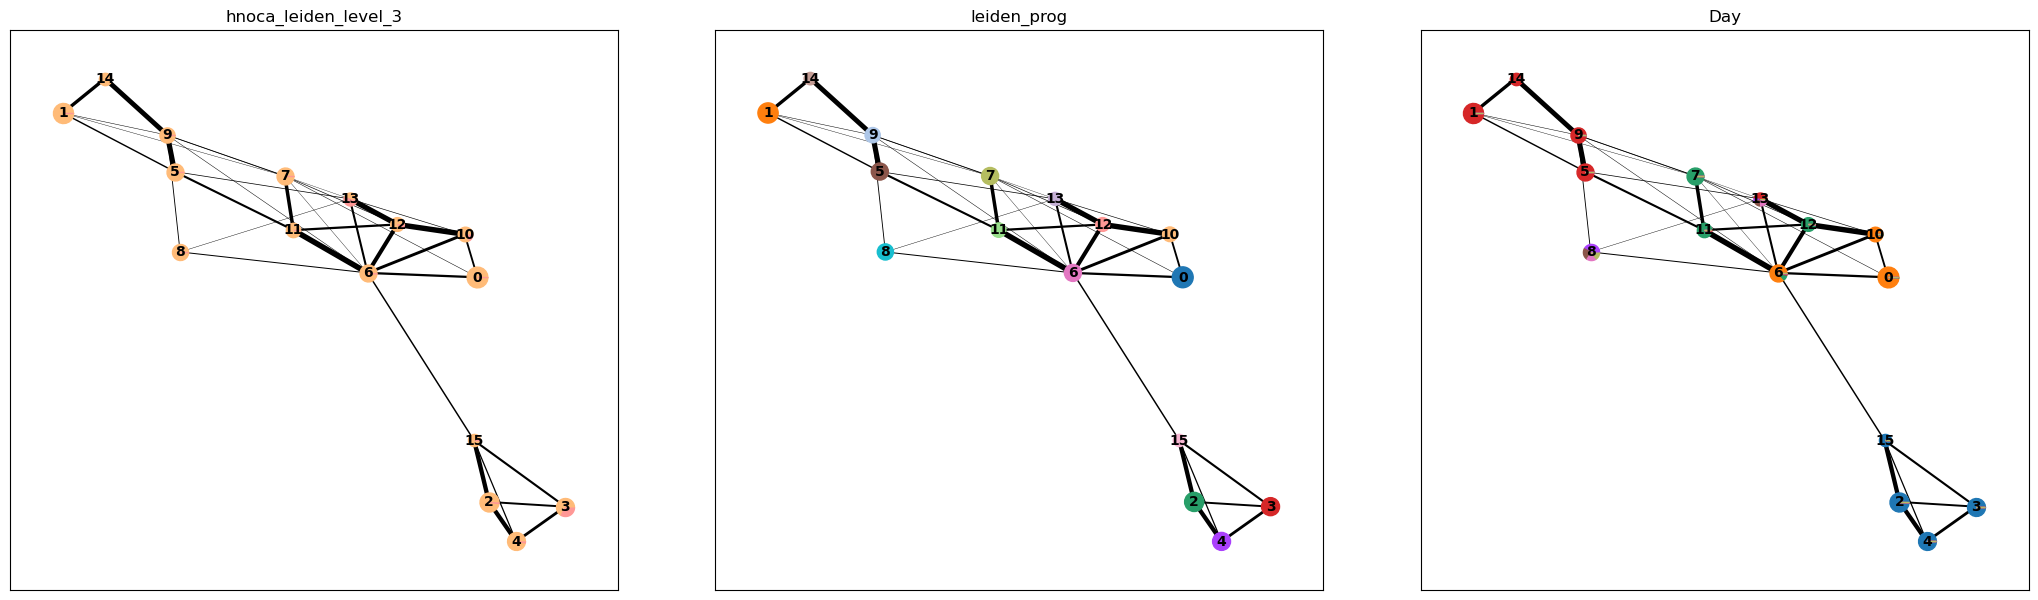

In [8]:
sc.tl.paga(query_adata, groups="leiden_prog")
sc.pl.paga(query_adata, color=["hnoca_leiden_level_3", 'leiden_prog','Day'],threshold=0.03)
sc.tl.umap(query_adata, init_pos='paga')

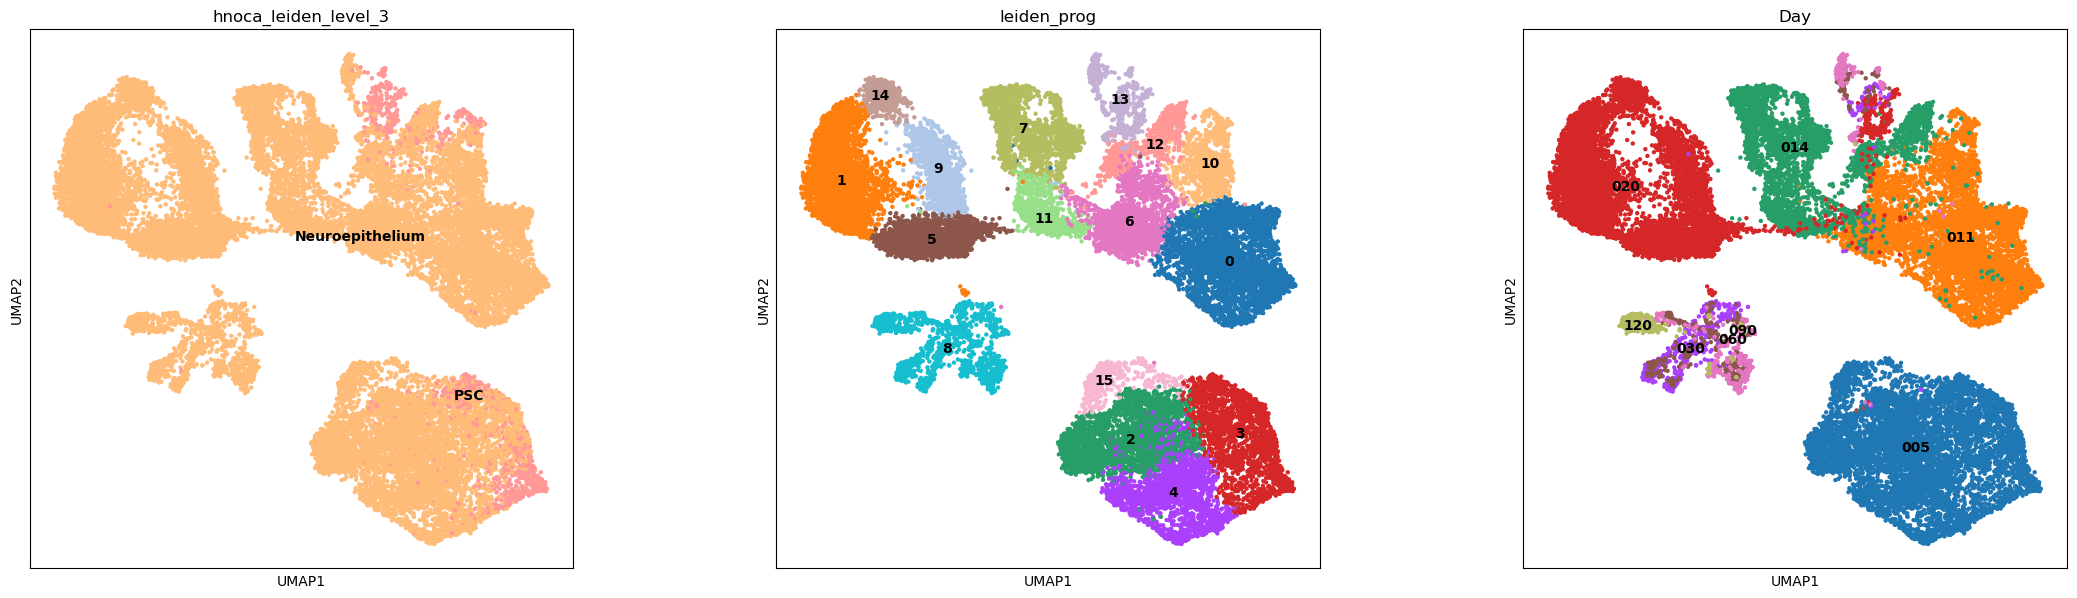

In [9]:
plt.rcParams['figure.figsize']=(7,7)
sc.pl.umap(query_adata, color=["hnoca_leiden_level_3", 'leiden_prog','Day'], wspace=0.25, size=40, legend_loc='on data')

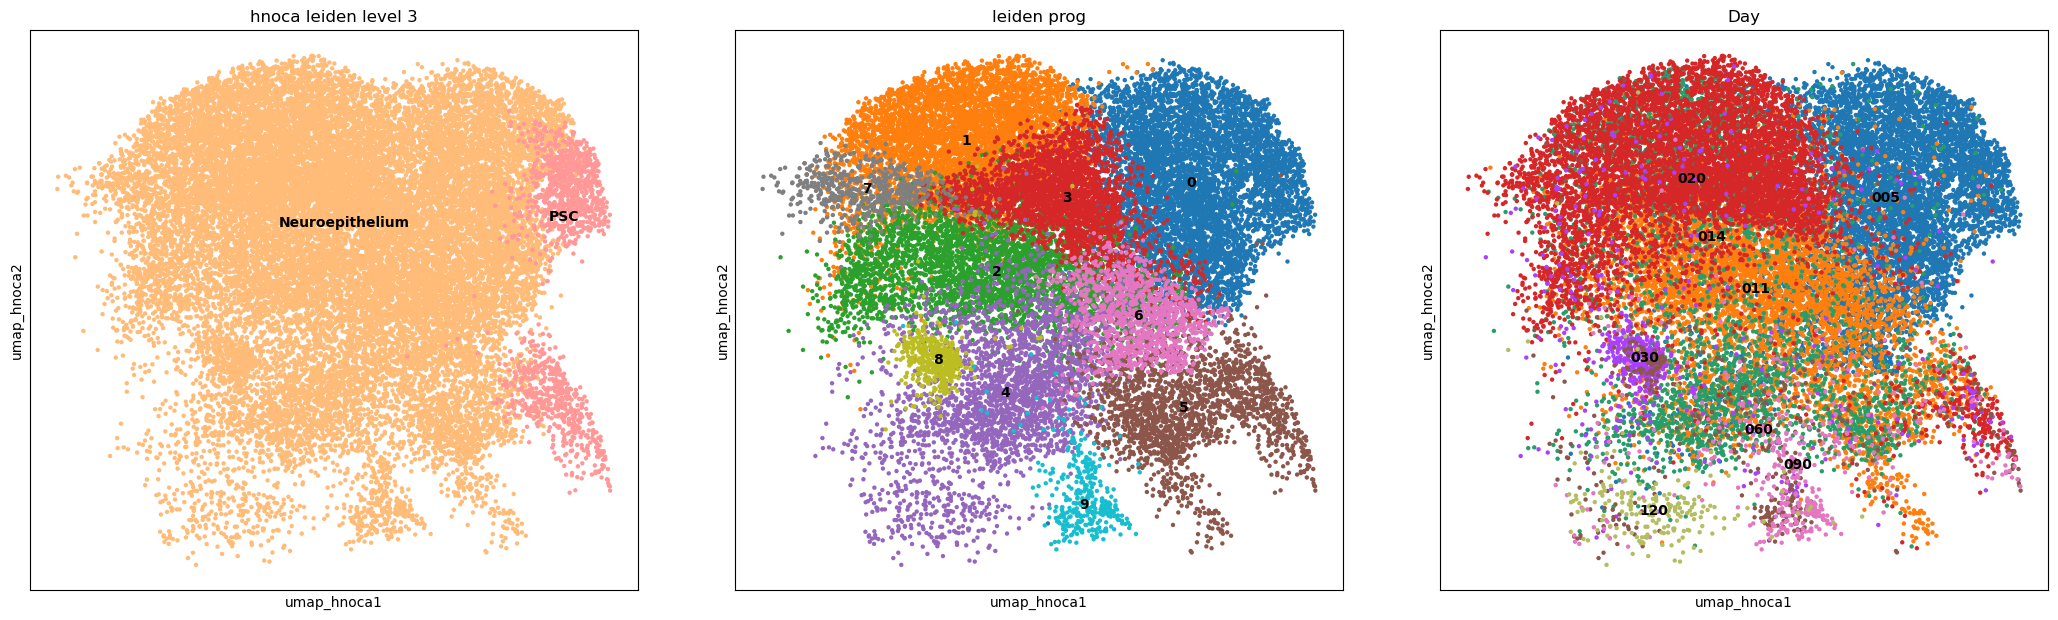

In [10]:
sc.pl.scatter(query_adata, basis="umap_hnoca", color=["hnoca_leiden_level_3", 'leiden_prog','Day'], size=40, legend_loc='on data')

We see two populations of PSC, which might be weird. We should check in detail cluster 5, to see whats happening.\
Also, there appears to be a dense outlier cluster of NE at day 30 (cl8) 

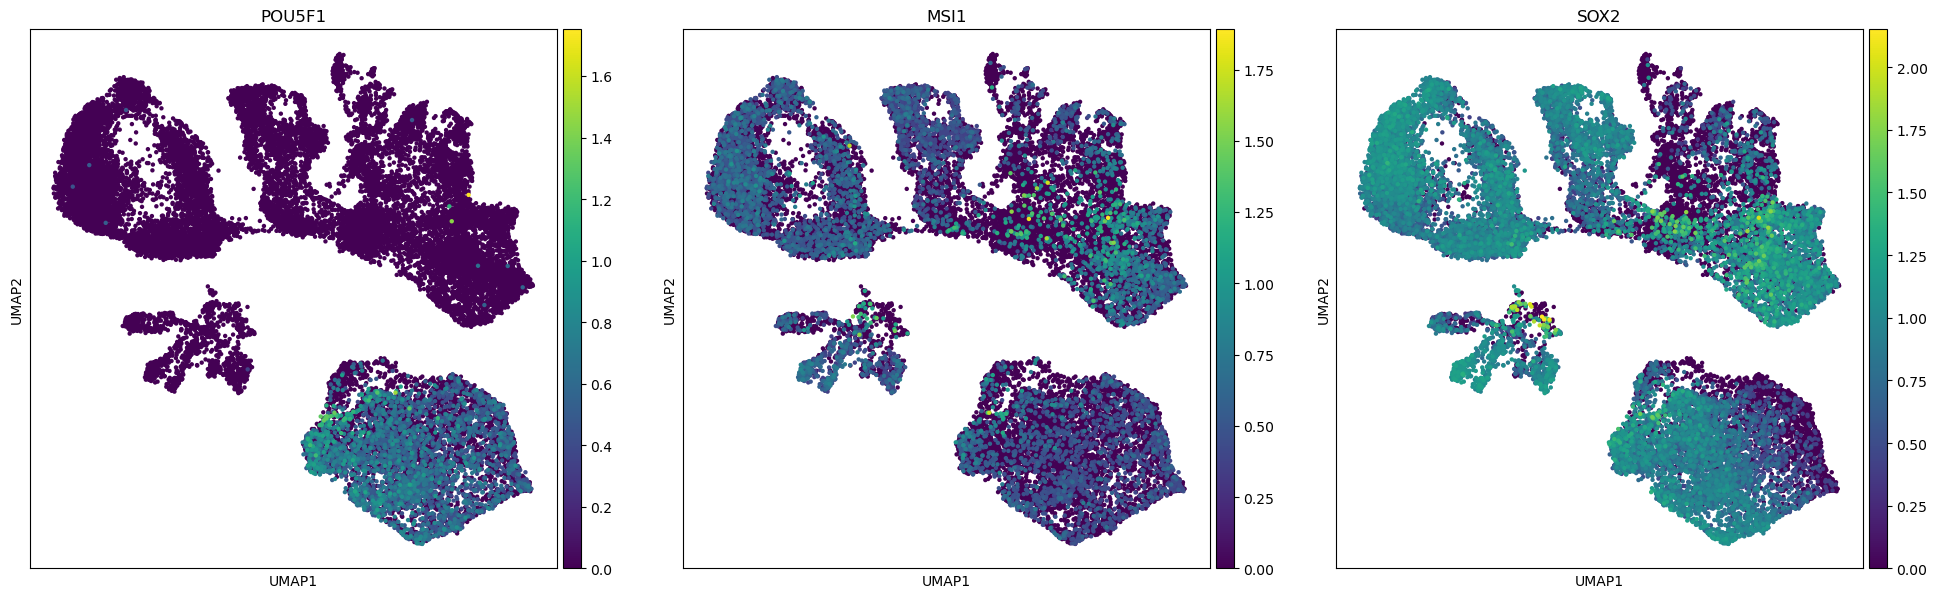

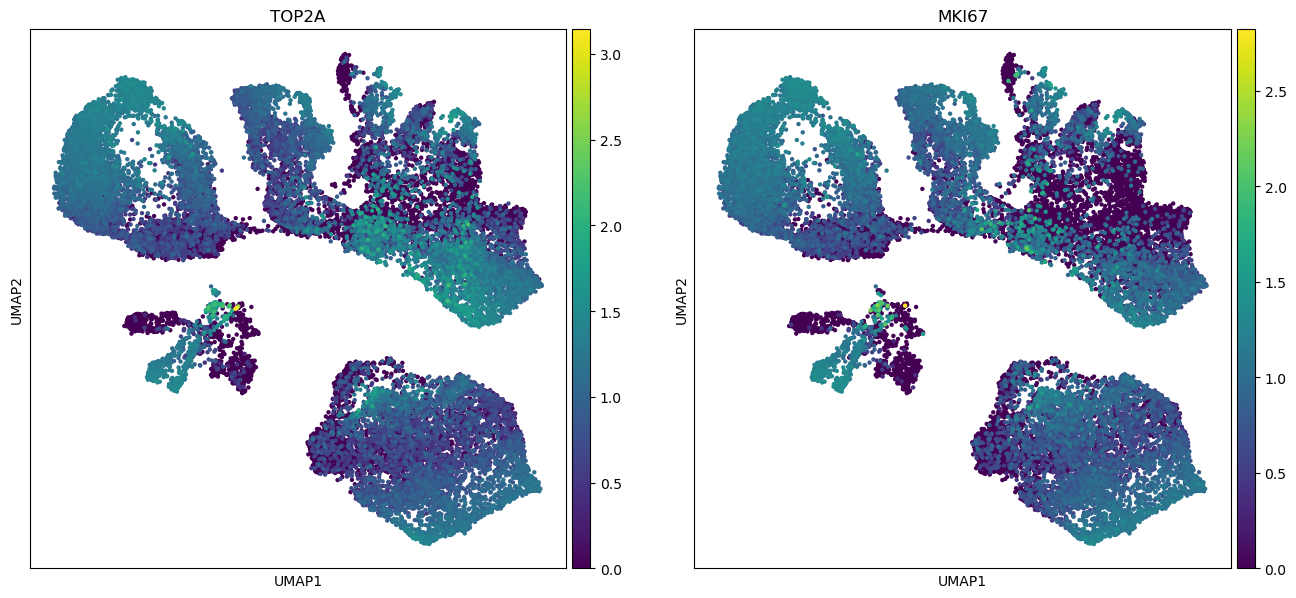

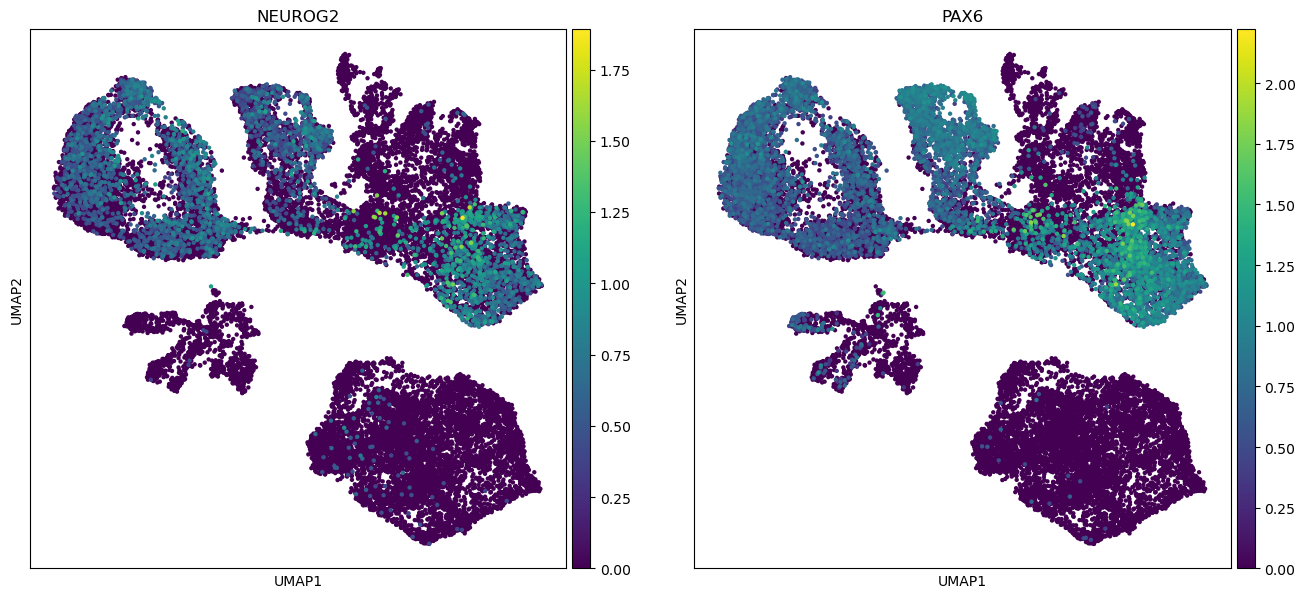

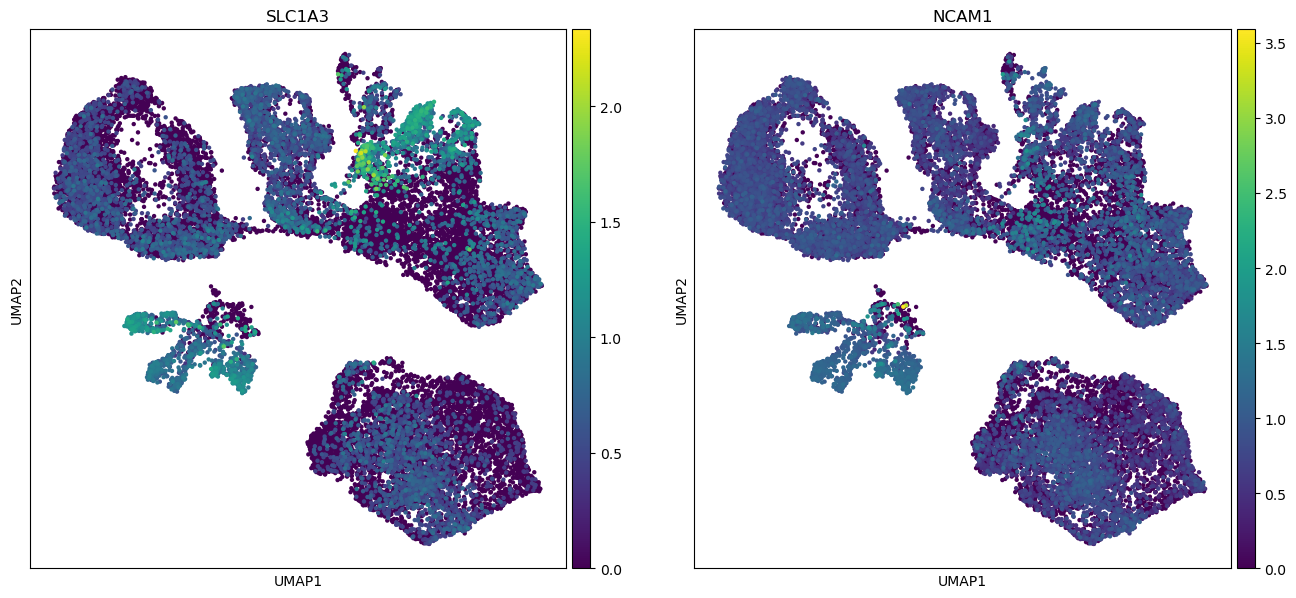

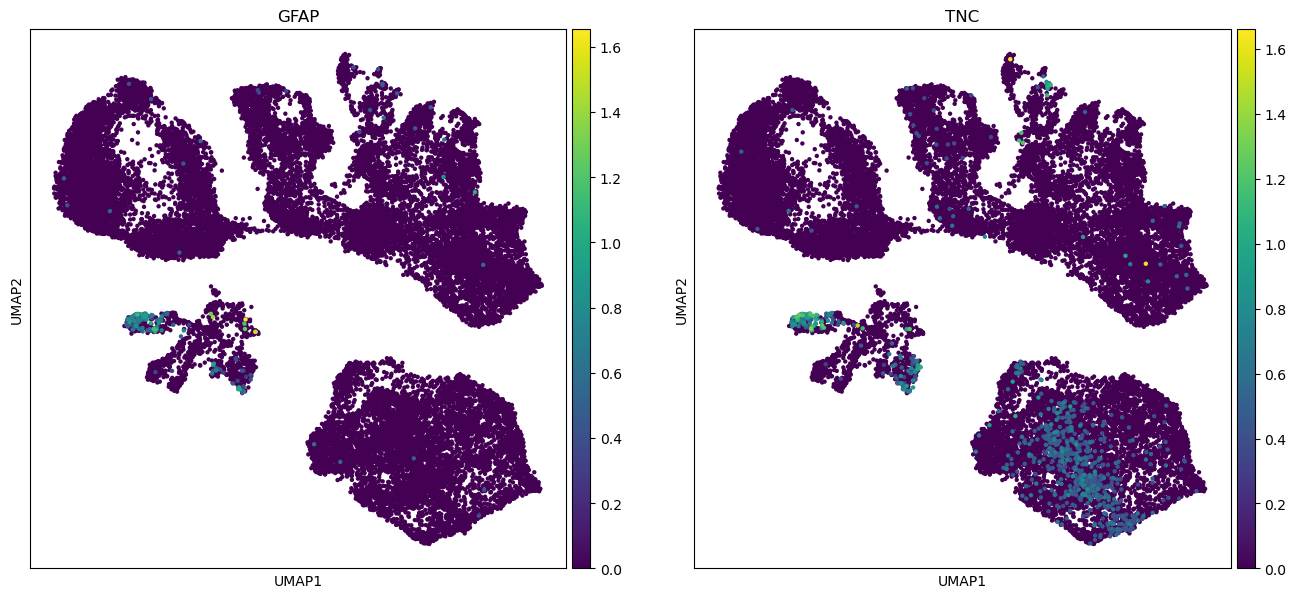

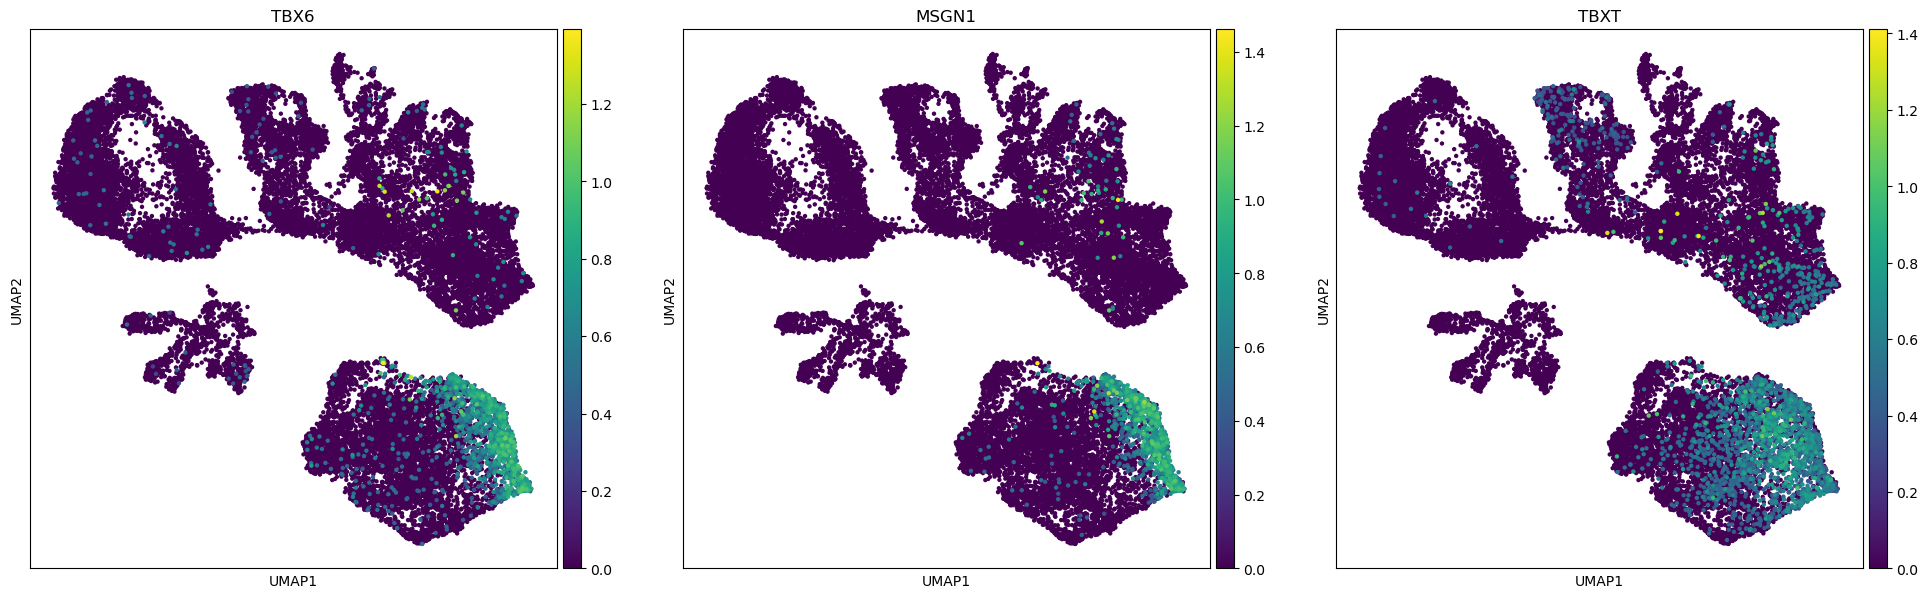

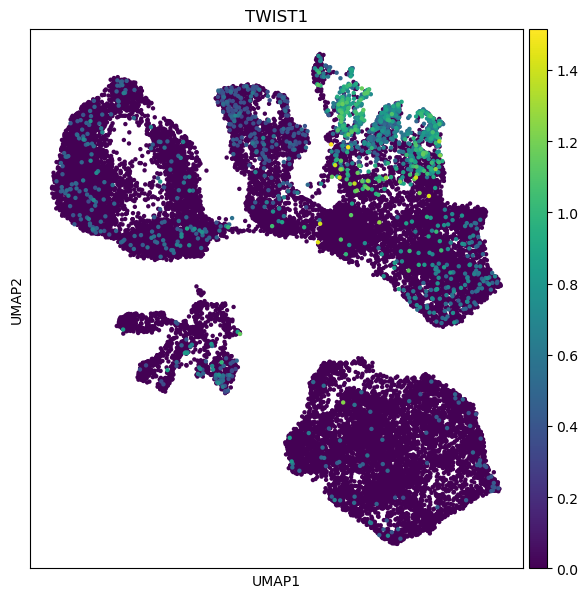

In [16]:
plt.rcParams['figure.figsize']=(7,7)
sc.pl.umap(query_adata, color=['POU5F1','MSI1','SOX2'], size=40) #PSC, NSC or NE?
sc.pl.umap(query_adata, color=['TOP2A','MKI67'], size=40) #cycling status
sc.pl.umap(query_adata, color=['NEUROG2',"PAX6"], size=40) #intermediate prog -> neurogenisis?
sc.pl.umap(query_adata, color=['SLC1A3','NCAM1'], size=40) #radial glia, SLC1A3=GLAST1
sc.pl.umap(query_adata, color=['GFAP','TNC'], size=40) #radial glia, late stage
sc.pl.umap(query_adata, color=['TBX6','MSGN1',"TBXT"], size=40) #mesodermal stem cells -> myogenisis
sc.pl.umap(query_adata, color=['TWIST1'], size=40) #EMT?

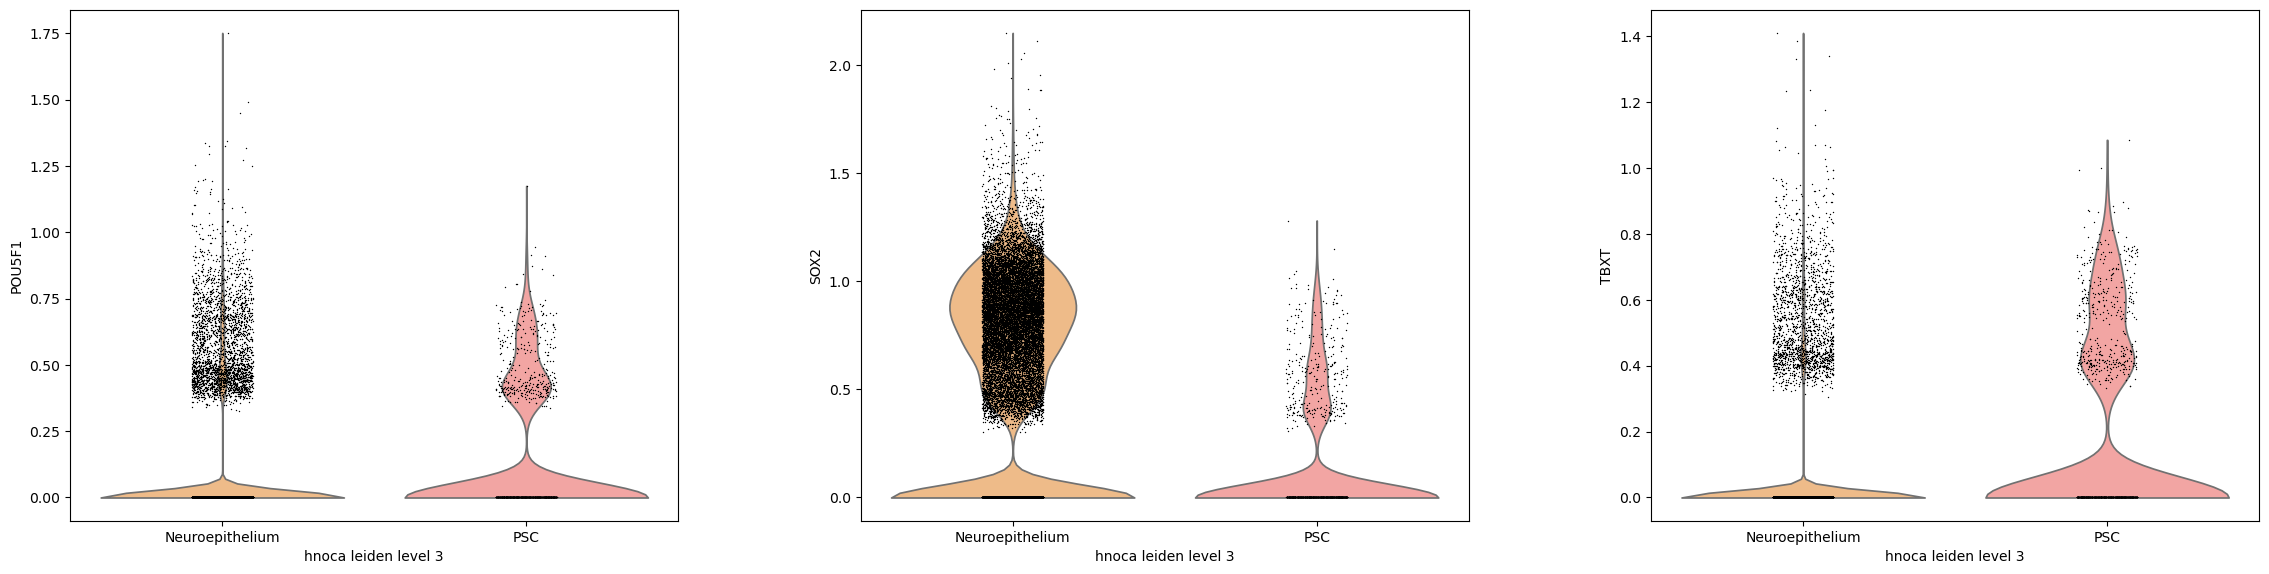

In [13]:
plt.rcParams['figure.figsize']=(7,7)
sc.pl.violin(query_adata, keys=['POU5F1','SOX2','TBXT'], groupby="hnoca_leiden_level_3")

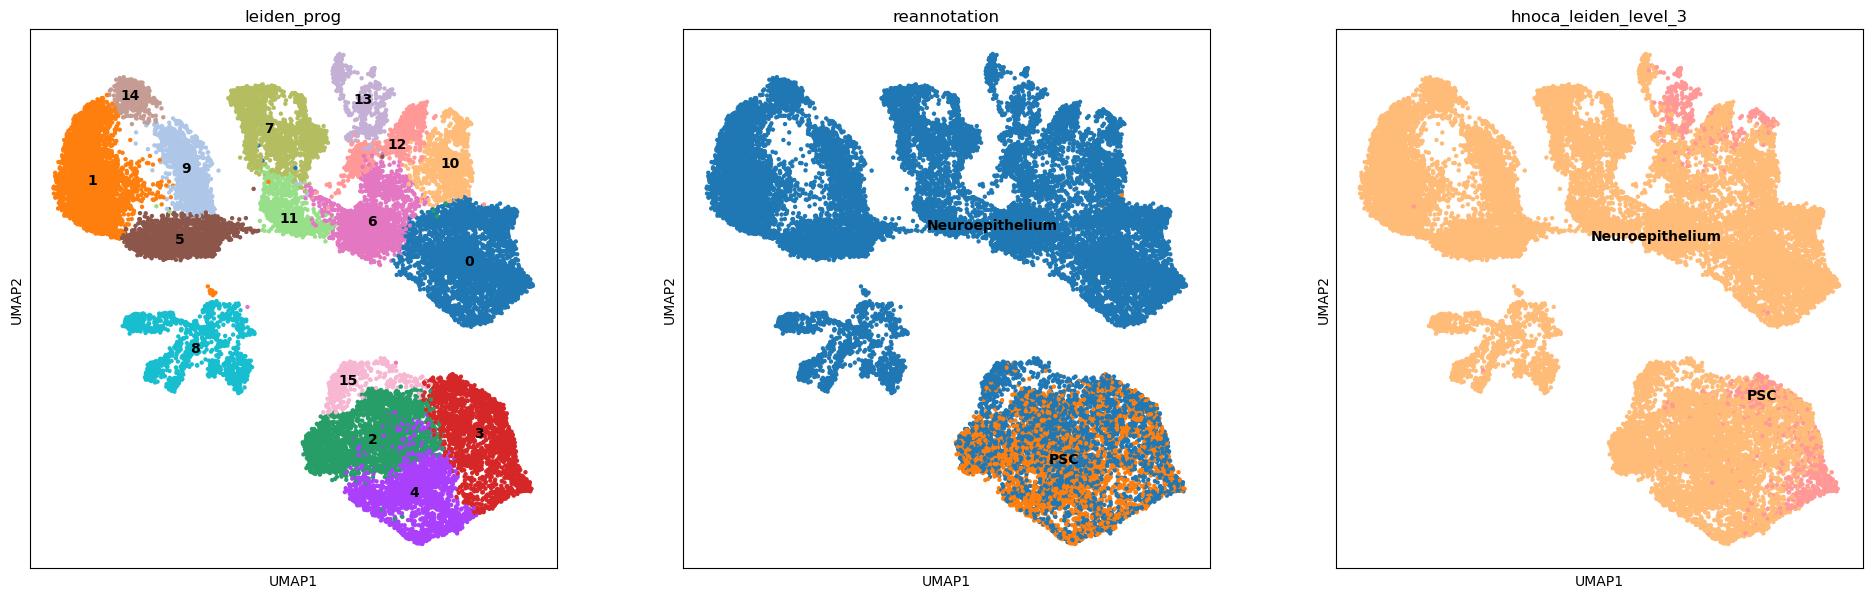

In [14]:
POU5F1 = query_adata[:,'POU5F1'].X.toarray().flatten()

query_adata.obs['reannotation'] = np.where(POU5F1 > 0, 'PSC', 'Neuroepithelium')
sc.pl.umap(query_adata, color=['leiden_prog','reannotation','hnoca_leiden_level_3'], size=40, legend_loc='on data')

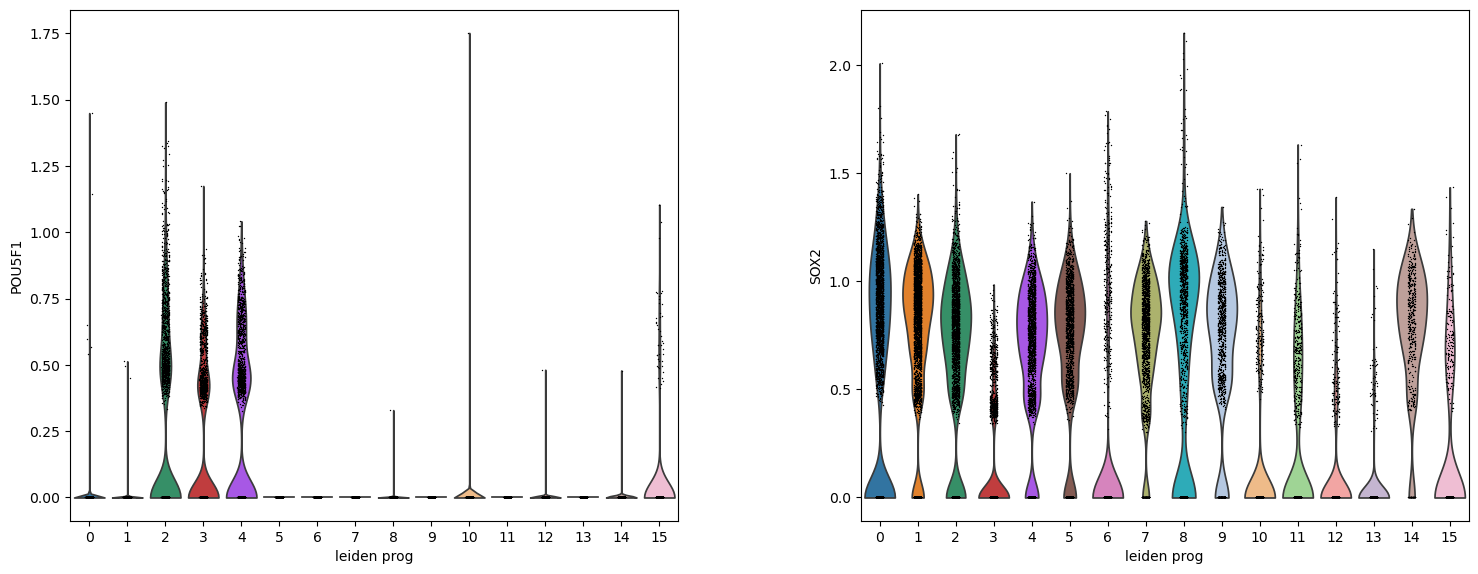

In [15]:
sc.pl.violin(query_adata, keys=['POU5F1','SOX2'], groupby='leiden_prog')

In [17]:
reannot = {"0":"Neuroepithelium",
    "1":"Neuroepithelium",
    "2":"Neuroepithelium",
    "3":"PSC",
    "4":"PSC",
    "5":"Neuroepithelium",
    "6":"Neuroepithelium",
    "7":"Neuroepithelium",
    "8":"Neuroepithelium",
    "9":"Neuroepithelium",
    "10":"Neuroepithelium",
    "11":"Neuroepithelium",
    "12":"Neuroepithelium",
    "!3":"Neuroepithelium",
    "14":"Neuroepithelium",
    "15":"Neuroepithelium",
}

In [18]:
adata.obs['leiden_prog'] = query_adata.obs['leiden_prog'].copy()
adata.obs['reannotation'] = adata.obs['leiden_prog'].map(reannot)
adata.obs['reannotation'].fillna(adata.obs['hnoca_leiden_level_1'], inplace=True)
print(adata.obs['reannotation'].value_counts())
print("")
print(adata.obs['hnoca_leiden_level_1'].value_counts())

Neuroepithelium    21062
NPC                17772
MC                  6515
PSC                 4536
Neuron              3617
Glioblast            998
OPC                  332
NC Derivatives       305
Astrocyte            190
Name: reannotation, dtype: int64

NPC                21336
Neuroepithelium    20688
MC                  6515
Neuron              3617
PSC                 1346
Glioblast            998
OPC                  332
NC Derivatives       305
Astrocyte            190
Name: hnoca_leiden_level_1, dtype: int64


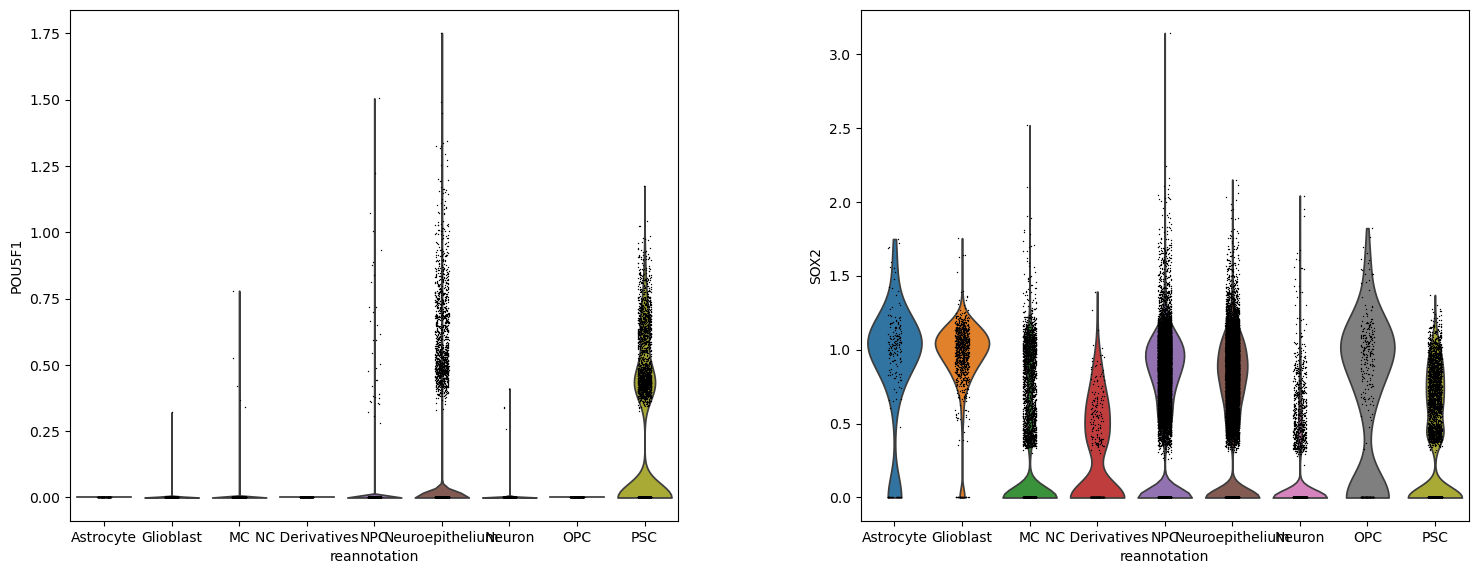

In [19]:
sc.pl.violin(adata, keys=['POU5F1','SOX2'], groupby='reannotation')

In [97]:
adata.obs['reannotation'].to_csv('/hpc/pmc_rios/2.personal/rariese/scseq_analysis/BRO/time_course/scripts/04_merge_annotations/reannotations/reannotation_progenitors.csv')